# DLS Assignment - 4

### This assignment was discussed with Tejasram Ramesh and Ramki Ramamurthy.

### For this assignment I referred the following resources:
  #### 1) Deep Learning with Python - by Francois Cholet
  #### 2) https://www.youtube.com/watch?v=zHTe9ehehX8
  #### 3) https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model
  #### 4) https://www.tensorflow.org/guide/core/matrix_core
  #### 5) https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/
  #### 6) https://www.tensorflow.org/api_docs/python/tf/compat/v1/initializers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import timeit
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Allocating to GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.278823552999995
GPU (s):
0.041053294000050755
GPU speedup over CPU: 79x


### Loading the MNIST Dataset

In [ ]:
mnist = tf.keras.datasets.mnist

In [ ]:
(train_images, train_labels) , (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
#Lets look at the training data
print("Training Images Shape: ",train_images.shape)
print("Training Labels: ",train_labels)


#Lets look at the testing data
print("Testing Images Shape: ",test_images.shape)
print("Testing Labels: ",test_labels)

Training Images Shape:  (60000, 28, 28)
Training Labels:  [5 0 4 ... 5 6 8]
Testing Images Shape:  (10000, 28, 28)
Testing Labels:  [7 2 1 ... 4 5 6]


### Normalizing the Images

In [ ]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images/=255
test_images/=255

### Loading the Model from Part 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/DLS_Assignments/Models/assign4_part1_baseline.h5'

In [ ]:
baseline = keras.models.load_model(model_path)

In [ ]:
evaluation = baseline.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.9856


### Performing Low Rank Approximation on the above model for D=20

In [ ]:
s_1 , U_1, V_1 = tf.linalg.svd(baseline.get_layer(index=1).get_weights()[0])
s_2 , U_2, V_2 = tf.linalg.svd(baseline.get_layer(index=2).get_weights()[0])
s_3 , U_3, V_3 = tf.linalg.svd(baseline.get_layer(index=3).get_weights()[0])
s_4 , U_4, V_4 = tf.linalg.svd(baseline.get_layer(index=4).get_weights()[0])
s_5 , U_5, V_5 = tf.linalg.svd(baseline.get_layer(index=5).get_weights()[0])



S_1 = tf.linalg.diag(s_1)
S_2 = tf.linalg.diag(s_2)
S_3 = tf.linalg.diag(s_3)
S_4 = tf.linalg.diag(s_4)
S_5 = tf.linalg.diag(s_5)



V_1T = tf.transpose(V_1)
V_2T = tf.transpose(V_2)
V_3T = tf.transpose(V_3)
V_4T = tf.transpose(V_4)
V_5T = tf.transpose(V_5)


r=20
U_r1 = U_1[:, :r]
U_r2 = U_2[:, :r]
U_r3 = U_3[:, :r]
U_r4 = U_4[:, :r]
U_r5 = U_5[:, :r]


V_S1 = tf.matmul(S_1[:r, :r], V_1T[:r, :])
V_S2 = tf.matmul(S_2[:r, :r], V_2T[:r, :])
V_S3 = tf.matmul(S_3[:r, :r], V_3T[:r, :])
V_S4 = tf.matmul(S_4[:r, :r], V_4T[:r, :])
V_S5 = tf.matmul(S_5[:r, :r], V_5T[:r, :])

In [ ]:
V_S1.shape

TensorShape([20, 1024])

In [ ]:
U_1.shape

TensorShape([784, 784])

In [ ]:
S_1.shape

TensorShape([784, 784])

In [ ]:
V_1T.shape

TensorShape([784, 1024])

### Creating the Model

In [ ]:
new_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(20,activation='relu',name='U_1_layer'),
    layers.Dense(1024, activation='relu', name='VXS_1_layer'),
    layers.Dense(20,activation='relu',name='U_2_layer'),
    layers.Dense(1024, activation='relu', name='VXS_2_layer'),
    layers.Dense(20,activation='relu',name='U_3_layer'),
    layers.Dense(1024, activation='relu', name='VXS_3_layer'),
    layers.Dense(20,activation='relu',name='U_4_layer'),
    layers.Dense(1024, activation='relu', name='VXS_4_layer'),
    layers.Dense(20,activation='relu',name='U_5_layer'),
    layers.Dense(1024, activation='relu', name='VXS_5_layer'),
    layers.Dense(10, name='output' ,activation='softmax')
])
print(new_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 U_1_layer (Dense)           (None, 20)                15700     
                                                                 
 VXS_1_layer (Dense)         (None, 1024)              21504     
                                                                 
 U_2_layer (Dense)           (None, 20)                20500     
                                                                 
 VXS_2_layer (Dense)         (None, 1024)              21504     
                                                                 
 U_3_layer (Dense)           (None, 20)                20500     
                                                                 
 VXS_3_layer (Dense)         (None, 1024)             

### Assigning U, V and Biases to the Model

In [ ]:
bias1 = new_model.get_layer(index=1).get_weights()[1]
bias2 = new_model.get_layer(index=2).get_weights()[1]
bias3 = new_model.get_layer(index=3).get_weights()[1]
bias4 = new_model.get_layer(index=4).get_weights()[1]
bias5 = new_model.get_layer(index=5).get_weights()[1]
bias6 = new_model.get_layer(index=6).get_weights()[1]
bias7 = new_model.get_layer(index=7).get_weights()[1]
bias8 = new_model.get_layer(index=8).get_weights()[1]
bias9 = new_model.get_layer(index=9).get_weights()[1]
bias10 = new_model.get_layer(index=10).get_weights()[1]

In [ ]:
new_model.get_layer(index=1).set_weights([U_r1,bias1])
new_model.get_layer(index=2).set_weights([V_S1,bias2])
new_model.get_layer(index=3).set_weights([U_r2,bias3])
new_model.get_layer(index=4).set_weights([V_S2,bias4])
new_model.get_layer(index=5).set_weights([U_r3,bias5])
new_model.get_layer(index=6).set_weights([V_S3,bias6])
new_model.get_layer(index=7).set_weights([U_r4,bias7])
new_model.get_layer(index=8).set_weights([V_S4,bias8])
new_model.get_layer(index=9).set_weights([U_r5,bias9])
new_model.get_layer(index=10).set_weights([V_S5,bias10])

In [ ]:
# new_weight1= new_model.get_layer(index=1).get_weights()[0]
# new_weight2= new_model.get_layer(index=2).get_weights()[0]
# new_weight3= new_model.get_layer(index=3).get_weights()[0]
# new_weight4= new_model.get_layer(index=4).get_weights()[0]
# new_weight5= new_model.get_layer(index=5).get_weights()[0]

In [ ]:
# new_bias1= new_model.get_layer(index=1).get_weights()[1]
# new_bias2= new_model.get_layer(index=2).get_weights()[1]
# new_bias3= new_model.get_layer(index=3).get_weights()[1]
# new_bias4= new_model.get_layer(index=4).get_weights()[1]
# new_bias5= new_model.get_layer(index=5).get_weights()[1]

In [ ]:
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc'],
)

### Training the Model

In [ ]:
history_new = new_model.fit(train_images , train_labels ,epochs = 30, batch_size = 256)

Epoch 1/30
235/235 [==============================] - 2s 4ms/step - loss: 0.8581 - acc: 0.7406
Epoch 2/30
235/235 [==============================] - 1s 4ms/step - loss: 0.2308 - acc: 0.9348
Epoch 3/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1553 - acc: 0.9556
Epoch 4/30
235/235 [==============================] - 1s 5ms/step - loss: 0.1246 - acc: 0.9636
Epoch 5/30
235/235 [==============================] - 1s 6ms/step - loss: 0.1020 - acc: 0.9699
Epoch 6/30
235/235 [==============================] - 1s 6ms/step - loss: 0.0874 - acc: 0.9741
Epoch 7/30
235/235 [==============================] - 1s 5ms/step - loss: 0.0793 - acc: 0.9762
Epoch 8/30
235/235 [==============================] - 1s 4ms/step - loss: 0.0692 - acc: 0.9789
Epoch 9/30
235/235 [==============================] - 1s 4ms/step - loss: 0.0618 - acc: 0.9810
Epoch 10/30
235/235 [==============================] - 1s 4ms/step - loss: 0.0579 - acc: 0.9826
Epoch 11/30
235/235 [============================

In [ ]:
print("The average training accuracy is :",np.mean(history_new.history['acc']))

The average training accuracy is : 0.9751949985822042


### Evaluating the Model

In [ ]:
evaluation = new_model.evaluate(test_images , test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1558 - acc: 0.9731


In [ ]:
print("The test accuracy is :",evaluation[1])

The test accuracy is : 0.9731000065803528


### Plotting the Loss and Accuracy of the model

Text(0.5, 1.0, 'Model Accuracy')

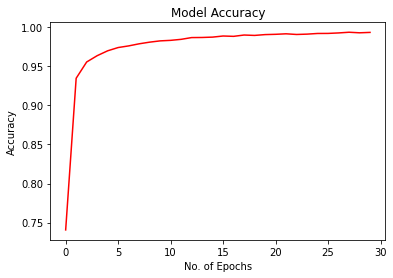

In [ ]:
plt.plot(history_new.history['acc'], color = 'red')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")
plt.title("Model Accuracy")

Text(0.5, 1.0, 'Model Loss')

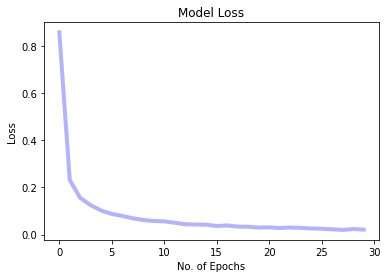

In [ ]:
plt.plot(history_new.history['loss'], color='blue',linewidth=4.0,alpha=0.3)
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")
plt.title("Model Loss")